# Bienestar en Bogotá - OPM
## Juan Diego Mayorga 
## MCPP
## 2022-1
-----
## Código Final
Este código contiene la metogolodía final para la descarga de datos de OSM

In [2]:
# Packages 

# OSM
#%pip install overpass
#%pip install OSMPythonTools]

import requests 
import overpass
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

# Data 
import pandas as pd
import json
from datetime import datetime,timedelta
import time

# Text 
import re

# Graphs 
import matplotlib.pyplot as plt
import seaborn as sns

-------
#### Descarga de bases de datos

Esta sección detallará como se descarga la infromación georeferenciada de los mapas de Bogotá a partir de la API de OSM
Esta sección contiene el código final del algoritmo. 

In [3]:
# Nos conectamos con la API
api = overpass.API(endpoint="https://overpass.myserver/interpreter")
api = overpass.API(timeout=600)

# Dejamos el link abierto para los request 
op_url = "https://overpass-api.de/api/interpreter" 

In [4]:
# Lista de las localidades para hacer un loop 
# Excluimos Sumapaz 
localidades = ["'Localidad Usaquén'", "'Localidad Chapinero'", "'Localidad Santa Fé'", "'Localidad San Cristóbal'", "'Localidad Usme'", "'Localidad Tunjuelito'",
    "'Localidad Bosa'", "'Localidad Kennedy'", "'Localidad Fontibón'", "'Localidad Engativá'", "'Localidad Suba'", "'Localidad Barrios Unidos'",
    "'Localidad Teusaquillo'", "'Localidad Los Mártires'", "'Localidad Antonio Nariño'", "'Localidad Puente Aranda'", "'Localidad La Candelaria'",
    "'Localidad Rafael Uribe Uribe'", "'Localidad Ciudad Bolivar'"]

# Las localidades estan en orden, necesitamos poner un indicador de la zona para lograr un merge con datos administrativos mas adelante
# Dado que vamos a hacer pruebas y el len puede que cambie a partir de la lista de localidades, vamos a hacer un comando que tome el tamaño de la lista 
index_loc = list(range(1,len(localidades)+1))
index_loc

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [31]:
# Primero saquemos la ubicación de todos los restaurantes de bogotá
# Tenemos que cambiar el formato del query, ya no necesitamos que nos cuente cuantos amentys tenemos sino el body de estos, para que nos arroje la latitud y longitud 
# Lo siguiente es un pequeño ejemplo de lo que será el código final, solo para hacer un test. 

final = []
op_query ="""
    [out:json][timeout:25];
    area[name='Localidad Usaquén']->.search;
    node["amenity"="university"](area.search);
    out body;
    out skel qt;
    """ 
# Importante mencionar que skel: Imprime la información mínima necesaria para la geometría:

# La respuesta viene en un formato json y por lo tanto necesitamos transformarla
response = requests.get(op_url, params={"data": op_query})
x = response.json()
data = pd.json_normalize(x["elements"])

# Debemos hacer un filtro para los datos que estan vacios 

if data.empty == True:
    print("No data")
else:
    # Extraemos la info que nos interesa, en este caso la longitud, latitud y nombre del establecimiento
    final = data[["lat", "lon", "tags.name"]]
    # Le ponemos el indice que nos permitirá conectar con el shp 
    final.insert(0,'Code_id', 1) # Usaquen es la localidad 1, pero mas adelante podemos ponerle un contador para que cambie dependiendo de la ubicación

    #final.to_excel("Data sets/OSM maps/Restaurante.xlsx",  index=False, encoding='utf-8-sig')

final

    # La base de datos final tiene la longitud, latitud y código de la localidad, lo que nos permitirá hacer un merge mas adelante

,Code_id,lat,lon,tags.name
0,1,4.694160,-74.033548,Universidad de los Andes -Práctica Médica
1,1,4.694737,-74.030419,UniSinú Sede Bogotá
2,1,4.742285,-74.046172,Universidad de San Buenaventura Bogotá Consult...
3,1,4.694160,-74.033548,NaN
4,1,4.694737,-74.030419,NaN
5,1,4.742285,-74.046172,NaN


In [44]:
# Para poder pegar el mapa con el shp file debemos hacer el cálculo por localidad para agregarle el identificador y que luego sea posible 
# unirlo con el shape file de bogotá. Por eso este loop será distinto al anterior.

def get_location(amenity):

    '''
La función get location recibe un argumento, el tipo de amenity que el usuario desee descargar de la base de datos de OSM. Como resultado final el usuario obtendra una base de datos que contenga lo siguiente
1. Latitud 
2. Longitud
3. Código de la localidad 
4. Tipo de amenity (Previendo que se harán multiples requests)
    '''

# Necesitamos un contador para enumerar las bases de datos
# Comienza en 1 porque necesitamos que construya las localidades; Recuerde que la lista de localidades está en orden
    contador = 1

    temp = pd.DataFrame([])

    for i in localidades:
    # En esta primera linea construimos el query. Recuerde que el query va a cambiar de localidad en localidad 
        p1 = """[out:json][timeout:50];"""
        p2 = """area[name=""" + i + """]->.search;"""
        p3 =  """node["amenity"=""" + amenity + """](area.search);out body;out skel qt;"""
        
    # Esta sigueinte línea conecta el query 
        op_query = p1 + p2 + p3
        
    # Acá nos conectamos con la API y le pasamos el query
        response = requests.get(op_url, params={"data": op_query})

    # La respuesta viene en un formato json y por lo tanto necesitamos transformarla
        x = response.json()
        data = pd.json_normalize(x["elements"])

    # Puede que algunas localidades no tengan valores para los amenitys que encontramos, por tanto, el código arrojará un error
        if data.empty == True:
           print("La "+str(i)+" no tiene datos disponibles para el amenity "+amenity)
           
        else:

            # Extraemos la info que nos interesa, en este caso la longitud, latitud y nombre del establecimiento
            final = data[["lat", "lon"]]

            # Le ponemos el indice que nos permitirá conectar con el shp 
            final.insert(0,'Objectid', contador)

            # Nombre de la localidad
            final.insert(0,"Localidad", str(i))
            
            # Le pegamos el nombre del amenity para hacer filtros mas adelante
            final.insert(0,"Amenity", str(amenity))

            # Guardamos las bases de datos individuales para tenerlas separadas para un análisis posterior 
            # Esto puede comentarse si el usuario no desea la información de forma individual
            #final.to_csv("Data sets/OSM maps/Localidad/" + str(i) + ".csv",  sep = ";", index=False, encoding='utf-8-sig')

            # Pegamos a la base de datos los datos de cada uno de los outputs de las localidades
            temp = temp.append(final)

            # Guardamos el archivo en un formato csv para conectarlo con tableur
            temp.to_csv("Data sets/OSM maps/" + str(amenity) + ".csv",  sep = ";", index=False, encoding='utf-8-sig')
        
        # Movemos el contador con cada loop; tiene que estar fuera del loop para que el indicador de cada localidad no se afecte
        # Recuerde que las localidades en la lista están en orden, por tanto, estas se pegarán de forma ordenada. Sin emabrgo, esto se debe ajustar para otros contextos
        contador += 1

    # La API no permite hacer cierto numero de querys al tiempo, por tanto, toca poner a dormir al código para que no nos saque 
    # Este puede ir cambiando, dado que vamos a hacer multiples request, puede que arroje errores a la hora de calcularlo 
    time.sleep(15)

    return temp

In [61]:
# Solo tenemos que correr la función para que en mi carpeta se guarde el archivo
# Hacemos pruebas para restaurantes y universidad
get_location("restaurant")
get_location("university")

La 'Localidad San Cristóbal' no tiene datos disponibles para el amenity university
La 'Localidad Usme' no tiene datos disponibles para el amenity university
La 'Localidad Tunjuelito' no tiene datos disponibles para el amenity university
La 'Localidad Bosa' no tiene datos disponibles para el amenity university
La 'Localidad Kennedy' no tiene datos disponibles para el amenity university
La 'Localidad Fontibón' no tiene datos disponibles para el amenity university
La 'Localidad Los Mártires' no tiene datos disponibles para el amenity university
La 'Localidad Antonio Nariño' no tiene datos disponibles para el amenity university
La 'Localidad Rafael Uribe Uribe' no tiene datos disponibles para el amenity university
La 'Localidad Ciudad Bolivar' no tiene datos disponibles para el amenity university


,Amenity,Localidad,Objectid,lat,lon
0,university,'Localidad Usaquén',1,4.694160,-74.033548
1,university,'Localidad Usaquén',1,4.694737,-74.030419
2,university,'Localidad Usaquén',1,4.742285,-74.046172
3,university,'Localidad Usaquén',1,4.694160,-74.033548
4,university,'Localidad Usaquén',1,4.694737,-74.030419
...,...,...,...,...,...
15,university,'Localidad Teusaquillo',13,4.630325,-74.071524
0,university,'Localidad Puente Aranda',16,4.600961,-74.104150
1,university,'Localidad Puente Aranda',16,4.600961,-74.104150
0,university,'Localidad La Candelaria',17,4.598514,-74.072445


Ahora, podemos hacer el request para multiples amenitys y juntar todo en una base de datos final

Dividiremos los amenityis por el tipo de información que se pueda llegar a tener 

**Entretenimiento, Arte y Cultura**

In [38]:
casino = get_location("casino")
cinema = get_location("cinema")
community_centre = get_location("community_centre")
love_hotel = get_location("love_hotel")
nightclub = get_location("nightclub")
theatre = get_location("theatre")

La 'Localidad Usme' no tiene datos disponibles para el amenity theatre
La 'Localidad Tunjuelito' no tiene datos disponibles para el amenity theatre
La 'Localidad Bosa' no tiene datos disponibles para el amenity theatre
La 'Localidad Kennedy' no tiene datos disponibles para el amenity theatre
La 'Localidad Fontibón' no tiene datos disponibles para el amenity theatre
La 'Localidad Suba' no tiene datos disponibles para el amenity theatre
La 'Localidad Barrios Unidos' no tiene datos disponibles para el amenity theatre
La 'Localidad Los Mártires' no tiene datos disponibles para el amenity theatre
La 'Localidad Puente Aranda' no tiene datos disponibles para el amenity theatre
La 'Localidad Rafael Uribe Uribe' no tiene datos disponibles para el amenity theatre
La 'Localidad Ciudad Bolivar' no tiene datos disponibles para el amenity theatre


In [39]:
# Unimos los df en una sola gran base de datos 
fun = pd.concat([cinema, community_centre, love_hotel, nightclub, theatre])

# Limpiamos los datos
# Principalmente eliminar el nombre de las localidades que puede ser un poco confuso 
fun['Localidad']=fun['Localidad'].str.extract(r'((?<=Localidad).*$)')

# Eliminamos la coma del final 
fun['Localidad']=fun['Localidad'].str[:-1]

fun.to_excel("Data sets/OSM maps/Final/fun.xlsx", index=False, encoding='utf-8-sig')

**Comida** 

In [47]:
bar = get_location("bar")
pub = get_location("pub")
cafe = get_location("cafe")
fast_food = get_location("fast_food")
restaurant = get_location("restaurant")

In [48]:
# Unimos los df en una sola gran base de datos 
food = pd.concat([bar, pub, cafe, fast_food, restaurant])

# Limpiamos los datos
# Principalmente eliminar el nombre de las localidades que puede ser un poco confuso 
food['Localidad']=food['Localidad'].str.extract(r'((?<=Localidad).*$)')

# Eliminamos la coma del final 
food['Localidad']=food['Localidad'].str[:-1]

# Guardamos la base de datos
food.to_excel("Data sets/OSM maps/Final/food.xlsx", index=False, encoding='utf-8-sig')

**Education**

In [50]:
uni_1 = get_location("college")
uni_2 = get_location("university")
pre_school = get_location("kindergarten")
colegio = get_location("school")

La 'Localidad Los Mártires' no tiene datos disponibles para el amenity kindergarten
La 'Localidad La Candelaria' no tiene datos disponibles para el amenity kindergarten


In [51]:
# Unimos los df en una sola gran base de datos 
edu = pd.concat([uni_1, uni_2, pre_school, colegio])

# Limpiamos los datos
# Principalmente eliminar el nombre de las localidades que puede ser un poco confuso 
edu['Localidad']=edu['Localidad'].str.extract(r'((?<=Localidad).*$)')

# Eliminamos la coma del final 
edu['Localidad']=edu['Localidad'].str[:-1]

edu.to_excel("Data sets/OSM maps/Final/edu.xlsx", index=False, encoding='utf-8-sig')

--------------------
### Análisis de los datos

Esta sección buscará describir los datos mas relevantes de las bases de datos que fueron construidas anteriormente. Este es un análisis **básico**, como se presentará mas adelante, el análisis exhaustivo se hará para las "Comidas". Adicionalmente, se generan unas bases de datos que serán utilizadas en tableur para graficar los resultados finales. 

##### 2.1 Comida

In [6]:
# Cargamos la base de datos
food = pd.read_excel("Data sets/OSM maps/Final/food.xlsx")

In [7]:
# Describimos los datos
food.describe()
# Tenemos 11.784 registros de amenitys relacionados con comida

,Codigo Loc,lat,lon,index
count,11784.000000,11784.000000,11784.000000,11784.000000
mean,8.545825,4.654643,-74.083610,5892.500000
std,5.402522,0.049826,0.033243,3401.892121
min,1.000000,4.470147,-74.211661,1.000000
25%,2.000000,4.618732,-74.102926,2946.750000
50%,10.000000,4.649043,-74.073248,5892.500000
75%,13.000000,4.691652,-74.061849,8838.250000
max,19.000000,4.819146,-74.010443,11784.000000


In [8]:
# Observamos que variables tenemos 
food.head()

,Amenity,Localidad,Codigo Loc,lat,lon,index,Ciudad,País,Location
0,bar,Usaquén,1,4.819146,-74.031994,1,Bogotá,Colombia,"Usaquén, Bogotá, Colombia"
1,bar,Usaquén,1,4.675118,-74.021478,2,Bogotá,Colombia,"Usaquén, Bogotá, Colombia"
2,bar,Usaquén,1,4.695780,-74.029649,3,Bogotá,Colombia,"Usaquén, Bogotá, Colombia"
3,bar,Usaquén,1,4.736958,-74.022126,4,Bogotá,Colombia,"Usaquén, Bogotá, Colombia"
4,bar,Usaquén,1,4.762657,-74.037163,5,Bogotá,Colombia,"Usaquén, Bogotá, Colombia"


In [9]:
# Desagregemos los distintos tipos de establecimientos, el siguiente código presenta las estadísticas básicas para cada uno de ellos
# Podemos ver que el amenity mas común de comida es Restaurante
food.groupby(['Amenity']).describe()

Codigo Loc                                                     lat  \
                count      mean       std  min  25%   50%   75%   max   count   
Amenity                                                                         
bar            1020.0  9.356863  4.831417  1.0  6.0  10.0  13.0  19.0  1020.0   
cafe           2134.0  8.130272  5.599619  1.0  2.0  10.0  13.0  19.0  2134.0   
fast_food      2004.0  8.920160  5.443819  1.0  3.0  10.0  13.0  19.0  2004.0   
pub             160.0  7.025000  5.872813  1.0  2.0   3.0  13.0  17.0   160.0   
restaurant     6466.0  8.476647  5.373605  1.0  2.0  10.0  13.0  19.0  6466.0   

                      ...        lon              index                       \
                mean  ...        75%        max   count    mean          std   
Amenity               ...                                                      
bar         4.649774  ... -74.068220 -74.012858  1020.0   510.5   294.592939   
cafe        4.648834  ... -74.062546 -74.010443  2134.0  2247.5   616.177058   
fast_food   4.653039  ... -74.063617 -74.020927  2004.0  4316.5   578.649289   
pub         4.658951  ... -74.054089 -74.030327   160.0  1100.5    46.332134   
restaurant  4.657720  ... -74.059661 -74.011940  6466.0  8551.5  1866.717752   

                                                        
               min      25%     50%       75%      max  
Amenity                                                 
bar            1.0   255.75   510.5    765.25   1020.0  
cafe        1181.0  1714.25  2247.5   2780.75   3314.0  
fast_food   3315.0  3815.75  4316.5   4817.25   5318.0  
pub         1021.0  1060.75  1100.5   1140.25   1180.0  
restaurant  5319.0  6935.25  8551.5  10167.75  11784.0  

[5 rows x 32 columns]

In [10]:
# Desagregamos la información por amenity 
food_ag = pd.DataFrame(food.groupby(['Amenity'], as_index=False)["Localidad"].count())
food_ag.sort_values(by=["Localidad"], inplace=True)
food_ag.rename(columns = {'Localidad':'Total'}, inplace = True)

food_ag.head()

,Amenity,Total
3,pub,160
0,bar,1020
2,fast_food,2004
1,cafe,2134
4,restaurant,6466


Text(0.5, 1.0, 'Tipos de amenities - Comida')

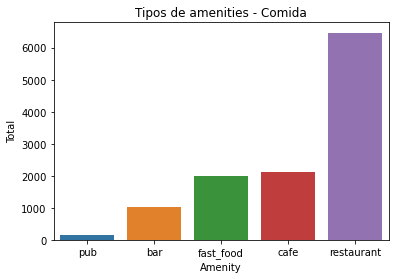

In [11]:
# Generamos un gráfico por amenity 
sns.barplot(x = "Amenity", y= "Total", data=food_ag)
plt.title("Tipos de amenities en Bogotá - Comida")

In [26]:
# Ahora agrupamos por amenity y por localidad
food_ag_loc = pd.DataFrame(food.groupby(["Localidad", "Amenity","Objectid"], as_index=False).count())

food_ag_loc = food_ag_loc[["Localidad", "Amenity", "Objectid", "lat"]]
food_ag_loc.rename(columns = {'lat':'Total'}, inplace = True)

# Guardamos la base de datos de comida agregada 
food_ag_loc.to_excel("Data sets/OSM maps/Final/food ag.xlsx", index=False, encoding='utf-8-sig')
food_ag_loc

,Localidad,Amenity,Objectid,Total
0,Antonio Nariño,bar,15,54
1,Antonio Nariño,cafe,15,50
2,Antonio Nariño,fast_food,15,38
3,Antonio Nariño,pub,15,2
4,Antonio Nariño,restaurant,15,88
...,...,...,...,...
82,Usaquén,restaurant,1,598
83,Usme,bar,5,4
84,Usme,cafe,5,6
85,Usme,fast_food,5,2


##### 2.2 Entretenimiento

In [12]:
# Cargamos la base de datos
fun = pd.read_excel("Data sets/OSM maps/Final/fun.xlsx")

In [13]:
# Describimos los datos
fun.describe()
# Tenemos 396 registros de amenitys relacionados con entretenimineto 
# Observamos que variables tenemos 

,Objectid,lat,lon
count,396.00000,396.000000,396.000000
mean,9.30303,4.642054,-74.092354
std,5.32385,0.052371,0.034477
min,1.00000,4.522437,-74.194615
25%,3.00000,4.600867,-74.109516
50%,10.00000,4.634153,-74.089346
75%,13.00000,4.680170,-74.066508
max,19.00000,4.763022,-74.024387


In [14]:
# Imprimimos las primeras filas
fun.head()

,Amenity,Localidad,Objectid,lat,lon
0,cinema,Usaquén,1,4.692672,-74.032975
1,cinema,Usaquén,1,4.715345,-74.029376
2,cinema,Usaquén,1,4.696440,-74.029700
3,cinema,Usaquén,1,4.703102,-74.041152
4,cinema,Usaquén,1,4.732038,-74.042615


In [15]:
# Desagregemos los distintos tipos de establecimientos, el siguiente código presenta las estadísticas básicas para cada uno de ellos
# Podemos ver que el amenity mas común de comida es Restaurante
fun.groupby(['Amenity']).describe()
# Desagregamos la información por amenity 
fun_ag = pd.DataFrame(fun.groupby(['Amenity'], as_index=False)["Localidad"].count())
fun_ag.sort_values(by=["Localidad"], inplace=True)
fun_ag.rename(columns = {'Localidad':'Total'}, inplace = True)

fun_ag.head()


,Amenity,Total
2,love_hotel,40
4,theatre,62
0,cinema,72
3,nightclub,100
1,community_centre,122


Text(0.5, 1.0, 'Tipos de amenities en Bogotá - Entretenimiento')

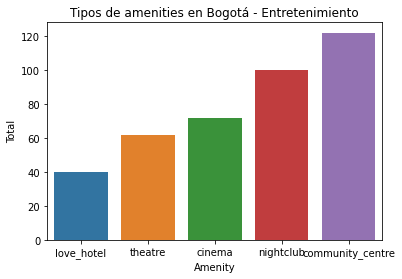

In [16]:
# Generamos un gráfico por amenity 
sns.barplot(x = "Amenity", y= "Total", data=fun_ag)

plt.title("Tipos de amenities en Bogotá - Entretenimiento")

In [27]:
# Ahora agrupamos por amenity y por localidad
fun_ag_loc = pd.DataFrame(fun.groupby(["Localidad", "Amenity", "Objectid"], as_index=False).count())

fun_ag_loc = fun_ag_loc[["Localidad", "Amenity", "Objectid", "lat"]]
fun_ag_loc.rename(columns = {'lat':'Total'}, inplace = True)

# Guardamos la base de datos de comida agregada 
fun_ag_loc.to_excel("Data sets/OSM maps/Final/fun ag.xlsx", index=False, encoding='utf-8-sig')
fun_ag_loc

,Localidad,Amenity,Objectid,Total
0,Antonio Nariño,love_hotel,15,34
1,Antonio Nariño,theatre,15,2
2,Barrios Unidos,cinema,12,8
3,Barrios Unidos,nightclub,12,4
4,Bosa,cinema,7,4
5,Bosa,community_centre,7,4
6,Chapinero,cinema,2,12
7,Chapinero,community_centre,2,8
8,Chapinero,nightclub,2,16
9,Chapinero,theatre,2,14


##### 2.3 Educación

In [17]:
# Cargamos la base de datos
edu = pd.read_excel("Data sets/OSM maps/Final/edu.xlsx")

In [18]:
# Describimos los datos
edu.describe()
# Tenemos 888 registros de amenitys relacionados con educación 

,Objectid,lat,lon
count,888.000000,888.000000,888.000000
mean,9.675676,4.659333,-74.094545
std,4.840010,0.065206,0.036270
min,1.000000,4.499192,-74.211852
25%,7.000000,4.611601,-74.119339
50%,10.000000,4.658766,-74.090813
75%,13.000000,4.707310,-74.069157
max,19.000000,4.813433,-74.004126


In [19]:
# Observamos que variables tenemos 
# Imprimimos las primeras filas
edu.head()

,Amenity,Localidad,Objectid,lat,lon
0,college,Usaquén,1,4.767958,-74.018586
1,college,Usaquén,1,4.702586,-74.031271
2,college,Usaquén,1,4.737053,-74.017149
3,college,Usaquén,1,4.764622,-74.032391
4,college,Usaquén,1,4.683618,-74.043593


In [20]:
# Desagregemos los distintos tipos de establecimientos, el siguiente código presenta las estadísticas básicas para cada uno de ellos
# Podemos ver que el amenity mas común de comida es Restaurante
edu.groupby(['Amenity']).describe()

Objectid                                                     lat  \
                count       mean       std  min  25%   50%   75%   max  count   
Amenity                                                                         
college          74.0   8.243243  5.521591  1.0  2.0  10.0  13.0  19.0   74.0   
kindergarten    166.0  10.939759  4.510861  1.0  9.0  11.0  13.0  19.0  166.0   
school          556.0   9.888489  4.548653  1.0  8.0  10.0  12.0  19.0  556.0   
university       92.0   7.260870  5.480975  1.0  2.0   3.0  13.0  17.0   92.0   

                        ...                        lon                       \
                  mean  ...       75%       max  count       mean       std   
Amenity                 ...                                                   
college       4.667132  ...  4.732480  4.803136   74.0 -74.078670  0.038576   
kindergarten  4.666120  ...  4.742052  4.758080  166.0 -74.100233  0.038482   
school        4.658615  ...  4.704369  4.813433  556.0 -74.099156  0.035567   
university    4.645151  ...  4.661429  4.744545   92.0 -74.069188  0.013608   

                                                                     
                    min        25%        50%        75%        max  
Amenity                                                              
college      -74.202819 -74.096678 -74.080382 -74.054977 -74.017149  
kindergarten -74.211852 -74.127139 -74.095128 -74.073944 -74.004126  
school       -74.197735 -74.122327 -74.097145 -74.071814 -74.016760  
university   -74.104150 -74.078122 -74.068866 -74.062384 -74.030419  

[4 rows x 24 columns]

In [21]:
# Desagregamos la información por amenity 
edu_ag = pd.DataFrame(edu.groupby(['Amenity'], as_index=False)["Localidad"].count())
edu_ag.sort_values(by=["Localidad"], inplace=True)
edu_ag.rename(columns = {'Localidad':'Total'}, inplace = True)

edu_ag.head()

,Amenity,Total
0,college,74
3,university,92
1,kindergarten,166
2,school,556


Text(0.5, 1.0, 'Tipos de amenities en Bogotá - Educación')

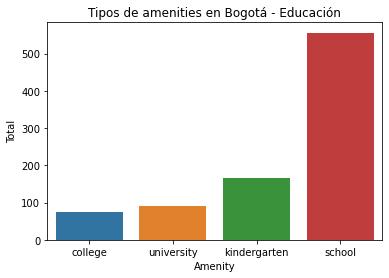

In [22]:
# Generamos un gráfico por amenity 
sns.barplot(x = "Amenity", y= "Total", data=edu_ag)
plt.title("Tipos de amenities en Bogotá - Educación")

In [9]:
# Ahora agrupamos por amenity y por localidad
edu_ag_loc = pd.DataFrame(edu.groupby(["Localidad", "Amenity", "Objectid"], as_index=False).count())

edu_ag_loc = edu_ag_loc[["Localidad", "Amenity", "Objectid", "lat"]]
edu_ag_loc.rename(columns = {'lat':'Total'}, inplace = True)

In [10]:
# Guardamos la base de datos de comida agregada 
edu_ag_loc.to_excel("Data sets/OSM maps/Final/edu ag.xlsx", index=False, encoding='utf-8-sig')
edu_ag_loc

,Localidad,Amenity,Objectid,Total
0,Antonio Nariño,kindergarten,15,2
1,Antonio Nariño,school,15,4
2,Barrios Unidos,kindergarten,12,4
3,Barrios Unidos,school,12,30
4,Barrios Unidos,university,12,10
5,Bosa,college,7,2
6,Bosa,kindergarten,7,6
7,Bosa,school,7,16
8,Chapinero,college,2,10
9,Chapinero,kindergarten,2,2
